In [6]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, AutoMinorLocator

In [43]:
x = np.linspace(-100.,100.,100)
y = np.exp(-x**2/2/15**2)

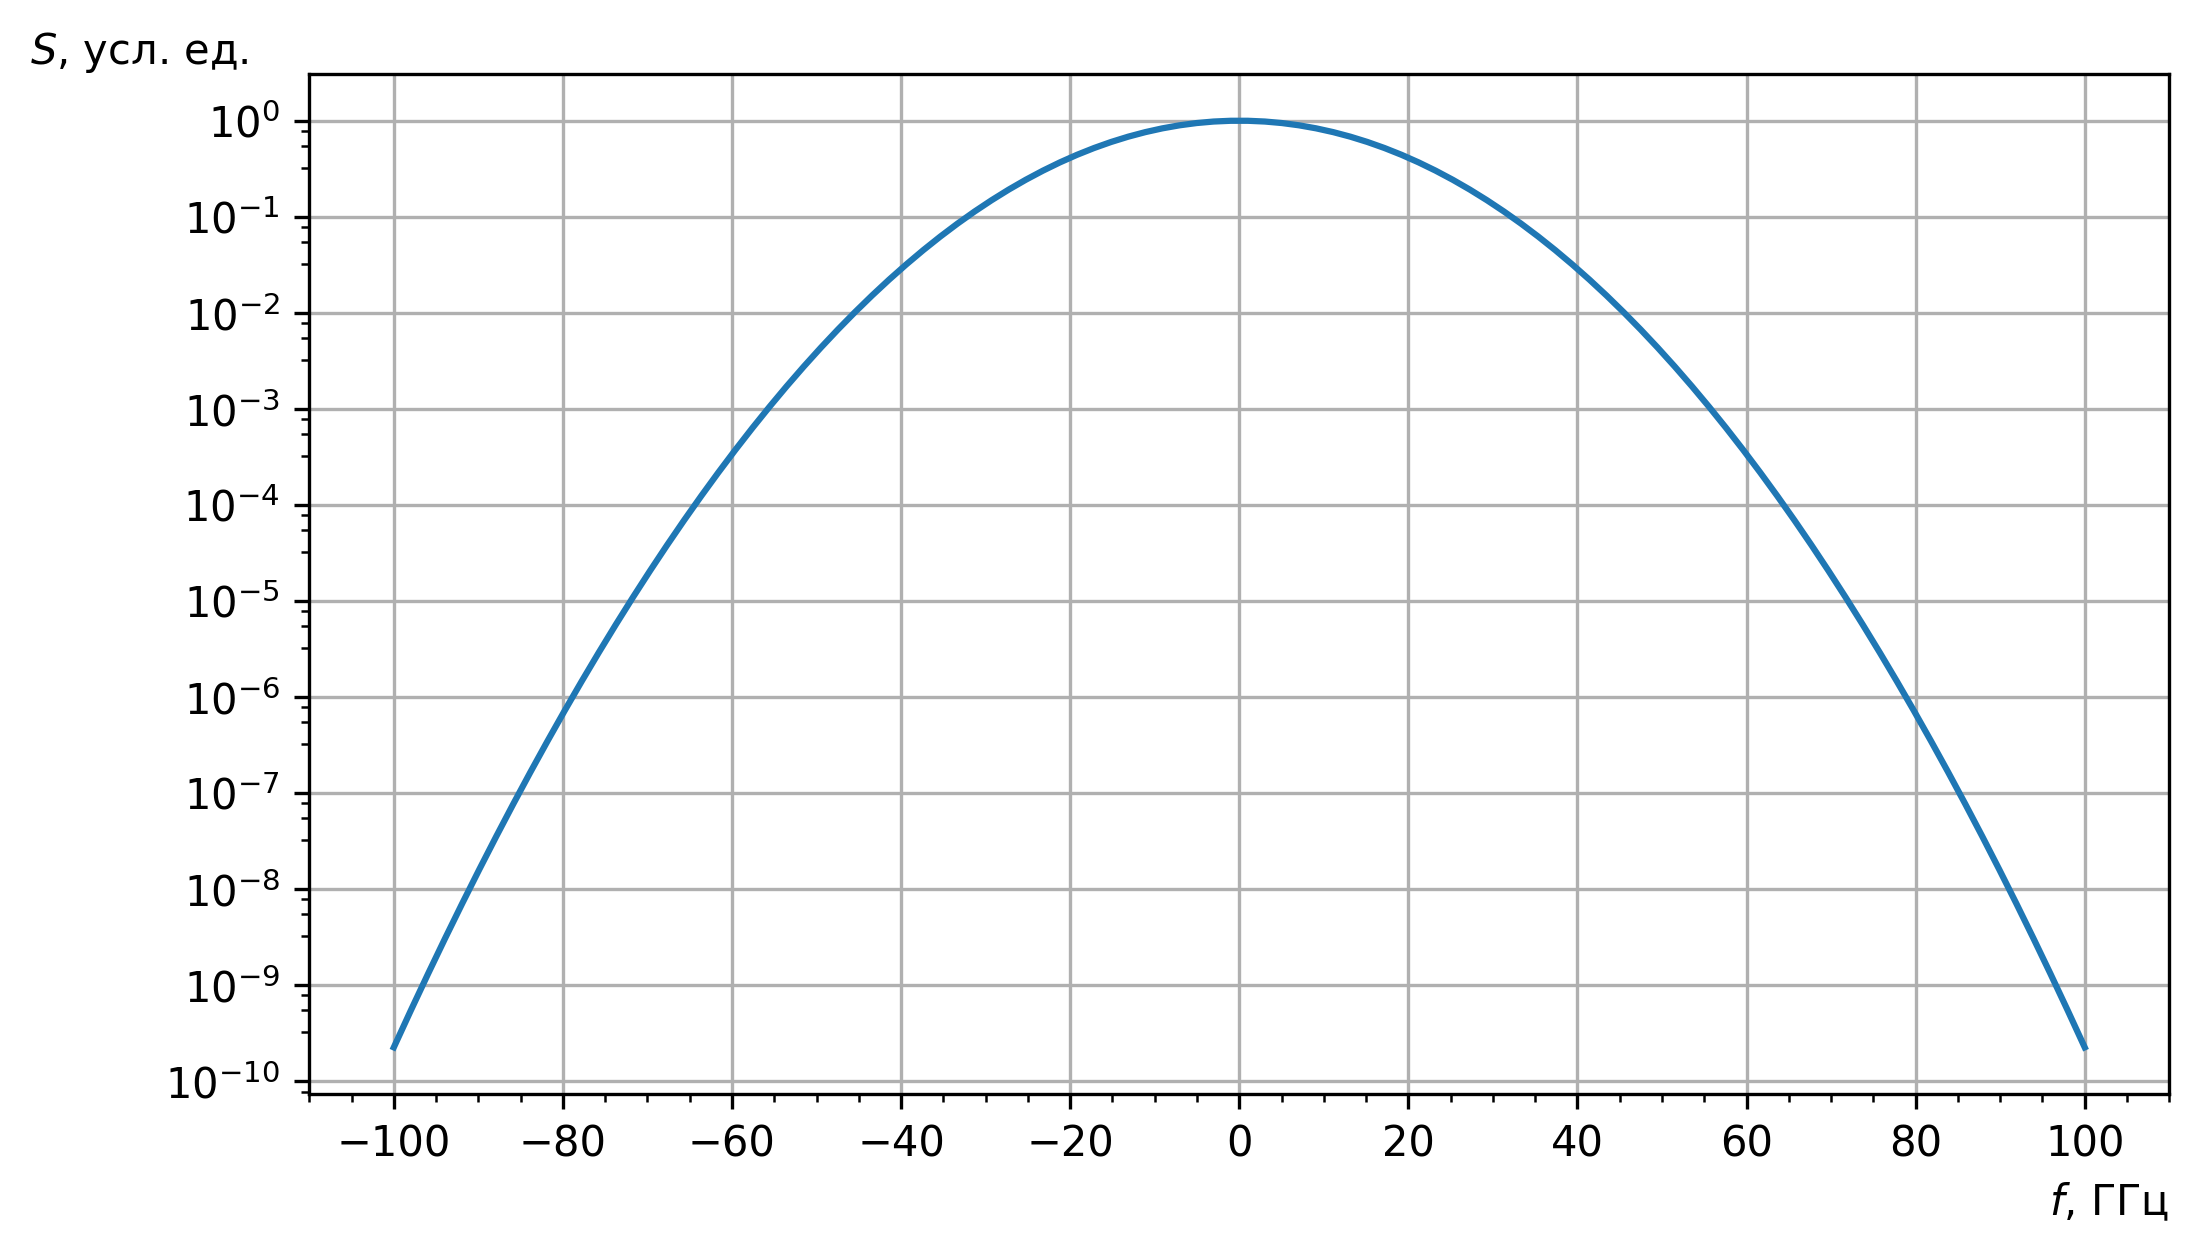

In [47]:
plt.figure(figsize=(8,4.5), dpi=300)
plt.plot(x,y)
ax = plt.gca()
ax.set_xlabel(r"$f$, ГГц", loc="right")
ax.set_ylabel(r"$S$, усл. ед.", loc="top", rotation="horizontal", labelpad=-20.)
ax.set_yscale("log")
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.linspace(1,10,5), numticks=15))
plt.grid()
plt.show()

In [37]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import lmfit
import scipy as sp

In [38]:
# import cpp lib for spectrum calculation and initialize argtypes for functions in it

lib = ctypes.CDLL("./getspec_dip.dll", winmode=0)

c_floating = ctypes.c_double;

class c_cfloating(ctypes.Structure): 
    """complex is a c structure
    https://docs.python.org/3/library/ctypes.html#module-ctypes suggests
    to use ctypes.Structure to pass structures (and, therefore, complex)
    """
    _fields_ = [("real", c_floating),("imag", c_floating)]
    @property
    def value(self):
        return self.real+1j*self.imag # fields declared above

c_floating_ptr = ctypes.POINTER(c_floating)
c_cfloating_ptr = ctypes.POINTER(c_cfloating)
c_uint_ptr = ctypes.POINTER(ctypes.c_uint)
c_int = ctypes.c_int

lib.reserve_complex_array.restype = c_cfloating_ptr
lib.reserve_complex_array.argtypes = [ctypes.c_int]
lib.reserve_array.restype = c_floating_ptr
lib.reserve_array.argtypes = [ctypes.c_int]
lib.reserve_twists.restype = c_cfloating_ptr
lib.reserve_twists.argtypes = [ctypes.c_int]
lib.reserve_bitrev.restype = c_uint_ptr
lib.reserve_bitrev.argtypes = [ctypes.c_int]

lib.free_array.restype = None
lib.free_array.argtypes = [c_floating_ptr]
lib.free_complex_array.restype = None
lib.free_complex_array.argtypes = [c_cfloating_ptr]
lib.free_uint_array.restype = None
lib.free_uint_array.argtypes = [c_uint_ptr]


lib.sdeeval.restype = ctypes.c_int
lib.sdeeval.argtypes = [c_floating_ptr, c_floating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr, c_cfloating_ptr,
                        c_cfloating_ptr, c_uint_ptr, c_int, c_int, c_int, c_int, c_floating, ctypes.c_bool,
                        c_floating, c_floating, c_floating, c_floating, c_floating, 
                        c_floating, c_floating, c_floating, c_floating, c_floating]

In [40]:
Npow = 16; 
L = 2**Npow;  # number of examined dots

# initialize arrays
twist = lib.reserve_twists(Npow)
bitrev = lib.reserve_bitrev(Npow)
Ex = lib.reserve_complex_array(L)
Ey = lib.reserve_complex_array(L)
tmpEx = lib.reserve_complex_array(L)
tmpEy = lib.reserve_complex_array(L)
specx = lib.reserve_array(L)
specy = lib.reserve_array(L)

In [42]:
Dt = 1e-6/4;
tau = 1e-4;
offset = 0.2;
Nav = 10;

tauDt = round(np.floor(tau/Dt));
if tauDt < 1:
    tauDt = 1
tau = tauDt * Dt;  # fix tau in order to make it right value

skip = round(offset * L);  # how many dots will be skipped by offset

freqs = np.linspace(-1/2/tau, 1/2/tau, 2**16)
fstep = freqs[1]-freqs[0]

In [ ]:
%%time
# FOR LARGE Nav use THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
spx = np.zeros((L,), dtype=np.double)
spy = np.zeros((L,), dtype=np.double)
ssx = np.zeros((L,), dtype=np.double)
ssy = np.zeros((L,), dtype=np.double)

filename = r'include_in_dip\fit450'

averaged = 0
res = 0
while averaged < Nav and res != -1:
    res = lib.sdeeval(specx, specy, Ex, Ey, tmpEx, tmpEy, 
                twist, bitrev, Npow, skip, Nav, tauDt, Dt, False, 
                *params450);
    ssx = np.ctypeslib.as_array(specx, (L,))
    ssy = np.ctypeslib.as_array(specy, (L,))
    if res < 0:
        spx = spx + Nav*ssx
        spy = spy + Nav*ssy
        averaged += Nav
        print(res)
        break;
    spx = spx + ssx
    spy = spy + ssy
    averaged += res
    print(res)


spx = spx / averaged
spy = spy / averaged


np.savetxt(filename+'.txt', np.transpose([freqs, spx, spy]))

WW = 2000
wnd = np.arange(round(freqs.shape[0]/2)-WW, round(freqs.shape[0])/2+WW, dtype=int)
plot_specs(freqs, spx, spy, wnd, filename+'.pdf')